# Fusion of Video and Audio features
## Without Doing Time Shifting
## Training on Synchronized Video and Audio Data

## Video and Audio data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 1

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, LSTM, Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling3D, TimeDistributed, ConvLSTM2D
from keras.layers.core import Permute, Reshape
from keras import backend as K


In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10


    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data = np.load(path+'Data_train_all.npz')
    Labels = Train_data['arr_1']
    Features_audio = Train_data['arr_2']
    Features_video = Train_data['arr_3']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_audio = Features_audio[randomize]
    Features_video = Features_video[randomize]
    
    #Features_video = Features_video.astype('float32')
    #Features_video /= 255
    
    new_Labels = np.split(Labels,[Labels.shape[0] - 1000])
    new_Features_audio = np.split(Features_audio,[Features_audio.shape[0] - 1000])
    new_Features_video = np.split(Features_video,[Features_video.shape[0] - 1000])
    
    return new_Labels[0],new_Features_audio[0],new_Features_video[0],new_Labels[1],new_Features_audio[1],new_Features_video[1]


def get_test_data(path=path):
    Train_data = np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Labels = Train_data[1]
    Features_audio = Train_data[2]
    Features_video = Train_data[3]

    Labels = one_hot_encoding(Labels)
    
    #new_Features_video = Features_video.astype('float32')
    #new_Features_video /= 255

    return Labels,Features_audio,Features_video

In [4]:
Labels,Features_audio,Features_video,Labels2,Features_audio2,Features_video2 = get_train_and_validate_data()
print(Labels.shape,Features_audio.shape,Features_video.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_audio2.shape,Features_video2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_audio3,Features_video3 = get_test_data()
print(Labels3.shape,Features_audio3.shape,Features_video3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(10976, 7) (10976, 193) (10976, 45, 64, 64, 3)
Train Classes distribution:  [1685. 2184. 1192. 1705. 1163. 1627. 1420.]
(1000, 7) (1000, 193) (1000, 45, 64, 64, 3)
Validate Classes distribution:  [148. 176. 116. 143. 109. 152. 156.]
(1377, 7) (1377, 193) (1377, 45, 64, 64, 3)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# Combined Model: Video + Audio

In [5]:
num_classes = 7

def combined_video_audio_model():
    input_audio = keras.layers.Input(shape=(193,))
    A1 = keras.layers.Dense(256, activation='relu')(input_audio)
    A2 = keras.layers.Dense(256, activation='relu')(A1)
    A3 = keras.layers.Dropout(0.3)(A2)


    input_video = keras.layers.Input(shape=(45, 64, 64, 3))
    V1 = keras.layers.Conv3D(32, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv1', input_shape=(45, 64, 64, 3))(input_video)
    V2 = keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='valid', name='pool1')(V1)

    V3 = keras.layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv2', input_shape=(45, 64, 64, 3))(V2)
    V4 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool2')(V3)

    V5 = keras.layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv3a')(V4)
    V6 = keras.layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv3b')(V5)
    V7 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool3')(V6)

    V8 = keras.layers.Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv4a')(V7)
    V9 = keras.layers.Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv4b')(V8)
    V10 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool4')(V9)

    V11 = keras.layers.Flatten()(V10)
    V12 = keras.layers.Dense(1024, activation='relu', name='fc1')(V11)
    V13 = keras.layers.Dropout(0.5)(V12)

    V14 = keras.layers.Dense(1024, activation='relu', name='fc2')(V13)
    V15 = keras.layers.Dropout(0.5)(V14)


    # equivalent to added = keras.layers.add([x1, x2])
    C1 = keras.layers.concatenate([A3, V15], axis=-1)
    C2 = keras.layers.Dense(128, activation='relu', name='combined_fc')(C1)

    out = keras.layers.Dense(num_classes, activation='softmax')(C2)

    model = keras.models.Model(inputs=[input_audio, input_video], outputs=out)
    
    return model


In [6]:
combined_model = combined_video_audio_model()

In [7]:
combined_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45, 64, 64,  0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 45, 64, 64, 3 2624        input_2[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling3D)            (None, 45, 32, 32, 3 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv3D)                  (None, 45, 32, 32, 6 55360       pool1[0][0]                      
_______________________________________________________________________________________

In [8]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/combined_model_checkpoint'

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [9]:
batch_size = 64
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
combined_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = combined_model.fit([Features_audio,Features_video], Labels,
                    verbose=0,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size,
                    callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=([Features_audio2,Features_video2], Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.72800, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.72800 to 0.75600, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.75600 to 0.82700, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.82700 to 0.84600, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.84600 to 0.88200, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.88200 to 0.92100, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy did not improve from 0.92100


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy did not improve from 0.92100


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy did not improve from 0.92100


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy improved from 0.92100 to 0.95200, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy improved from 0.95200 to 0.95700, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.95700


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy improved from 0.95700 to 0.96400, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy did not improve from 0.96400


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy improved from 0.96400 to 0.96500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy did not improve from 0.96500


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy did not improve from 0.96500


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy did not improve from 0.96500


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy improved from 0.96500 to 0.97500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy did not improve from 0.97500


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy did not improve from 0.97500


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy improved from 0.97500 to 0.98200, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\combined_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy did not improve from 0.98200


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy did not improve from 0.98200


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy did not improve from 0.98200


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy did not improve from 0.98200


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy did not improve from 0.98200
---Time 2612.6713032722473 seconds ---


# Accuracies

In [10]:
from keras.models import load_model

model = load_model(model_path)

In [11]:
#Train Accuracy
model.evaluate([Features_audio,Features_video],Labels)

343/343 [==============================] - 36s 104ms/step - loss: 0.0622 - accuracy: 0.9755


[0.06223423406481743, 0.975492000579834]

In [12]:
## Valid Accuracy
model.evaluate([Features_audio2,Features_video2],Labels2)

32/32 [==============================] - 3s 102ms/step - loss: 0.0532 - accuracy: 0.9820


[0.05322924628853798, 0.9819999933242798]

In [13]:
## Test Accuracy
model.evaluate([Features_audio3,Features_video3],Labels3)

44/44 [==============================] - 4s 100ms/step - loss: 0.3246 - accuracy: 0.9063


[0.32464662194252014, 0.9063180685043335]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


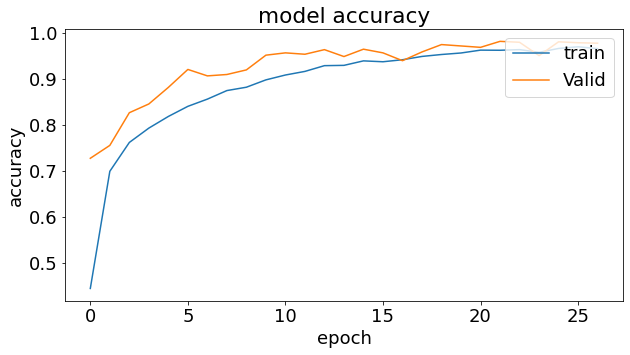

In [14]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

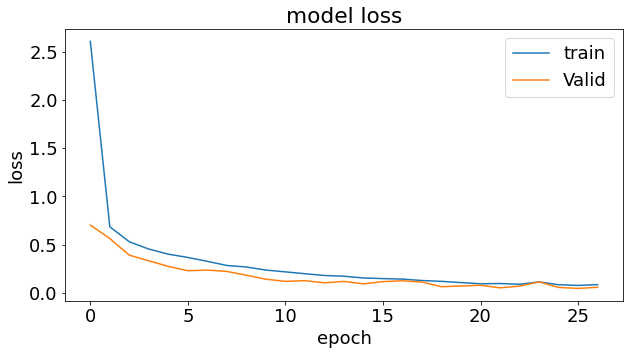

In [15]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()